In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import sys

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from pathlib import Path
from hydra import initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
import tqdm
import torch
import matplotlib.pyplot as plt

from tbfm import film
from tbfm import multisession
from tbfm import utils

DATA_DIR = "/home/mmattb/Projects/opto-coproc/data"
sys.path.append(DATA_DIR)
# imported from JNE project
import dataset
meta = dataset.load_meta(DATA_DIR)

OUT_DIR = "data"  # Local data cache; i.e. not reading from the opto-coproc folder.
EMBEDDING_REST_SUBDIR = "embedding_rest"

conf_dir = Path("./conf").resolve()

# Initialize Hydra with the configuration directory
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml

DEVICE = "cuda" #cfg.device
WINDOW_SIZE = cfg.data.trial_len
NUM_HELD_OUT_SESSIONS = cfg.training.num_held_out_sessions

In [2]:
# Okay, now a stim data loader...
# held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1", "MonkeyG_20150917_Session1_M1"]   # 10ms, 10ms, 10ms
# held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1"],
# held_in_session_ids=["MonkeyG_20150925_Session2_S1"],
# held_in_session_ids=[
#     "MonkeyG_20150914_Session1_S1",
#     "MonkeyG_20150915_Session3_S1",
#     "MonkeyG_20150915_Session5_S1",
#     "MonkeyG_20150916_Session4_S1",
#     "MonkeyG_20150917_Session1_M1",
#     "MonkeyG_20150917_Session1_S1",
#     "MonkeyG_20150917_Session2_M1",
#     "MonkeyG_20150917_Session2_S1",
#     "MonkeyG_20150921_Session3_S1",
#     "MonkeyG_20150921_Session5_S1",
#     "MonkeyG_20150922_Session1_S1",
#     "MonkeyG_20150922_Session2_S1",
#     "MonkeyG_20150925_Session1_S1",
#     "MonkeyG_20150925_Session2_S1",
#     "MonkeyJ_20160426_Session2_S1",
#     "MonkeyJ_20160426_Session3_S1",
#     "MonkeyJ_20160428_Session3_S1",
#     "MonkeyJ_20160429_Session1_S1",
#     "MonkeyJ_20160502_Session1_S1",
#     "MonkeyJ_20160624_Session3_S1",
#     "MonkeyJ_20160625_Session4_S1",
#     "MonkeyJ_20160625_Session5_S1",
#     "MonkeyJ_20160627_Session1_S1",
#     "MonkeyJ_20160630_Session3_S1",
#     "MonkeyJ_20160702_Session2_S1",
# ]

try:
    num_sessions = len(held_in_session_ids)
except NameError:
    num_sessions = 40 - NUM_HELD_OUT_SESSIONS
MAX_BATCH_SIZE = 60000
batch_size = (MAX_BATCH_SIZE // num_sessions) * num_sessions

d, held_out_session_ids = multisession.load_stim_batched(                                                             
    window_size=WINDOW_SIZE,                                                               
    session_subdir="torchraw",                                                     
    data_dir=DATA_DIR,
    unpack_stiminds=True,
    # held_in_session_ids=held_in_session_ids,
    batch_size=batch_size,
    num_held_out_sessions=NUM_HELD_OUT_SESSIONS,                                                      
)
data_train, data_test = d.train_test_split(6000, test_cut=2500)

held_in_session_ids = data_train.session_ids

# Gather cached rest embeddings...
embeddings_rest = multisession.load_rest_embeddings(held_in_session_ids, device=DEVICE)

In [3]:
# Customize cfg here...
# Now build...

# At 30 sessions we have fewer examples per session, so AE lrs need to go down. Noisier gradients.
# cfg.ae.training.coadapt = False
# cfg.training.grad_clip = 3.0
# cfg.tbfm.module.num_bases = 20
cfg.training.epochs = 30001

ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
model_optims = multisession.get_optims(cfg, ms)

Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!


In [ ]:
# Cleared for takeoff...
embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=1000,
    epochs=cfg.training.epochs,
    model_save_path="1st.torch")

---- 0 1.042707085609436 0.8772077560424805 0.08073587149381638 0.13138528168201447
---- 1000 0.6491872072219849 0.6763448417186737 0.34761769900098444 0.33848918974399567


In [6]:
torch.save(embeddings_stim, "es_1.torch")
torch.save(results, "r_1.torch")
torch.save(held_in_session_ids, "hisi_1.torch")

In [6]:
print(results["final_test_r2s"])
print(results['final_test_r2s']["MonkeyG_20150925_Session2_S1"])

NameError: name 'results' is not defined

In [7]:
print(embeddings_rest['MonkeyG_20150925_Session2_S1'])
print(embeddings_rest['MonkeyJ_20160630_Session3_S1'])
print(embeddings_rest['MonkeyG_20150917_Session1_M1'])
print(embeddings_stim['MonkeyG_20150925_Session2_S1'])
print(embeddings_stim['MonkeyJ_20160630_Session3_S1'])
print(embeddings_stim['MonkeyG_20150917_Session1_M1'])

tensor([0.3163, 0.3348, 0.3501], device='cuda:0')
tensor([0.2292, 0.2772, 0.3633], device='cuda:0')
tensor([0.1644, 0.1701, 0.1845], device='cuda:0')
tensor([-0.1568,  0.1482, -0.0599,  0.0392,  0.0867,  0.2132, -0.0157, -0.1204,
         0.0939,  0.0991,  0.0616, -0.0594, -0.0313,  0.0415, -0.1041],
       device='cuda:0')
tensor([ 0.0629,  0.0801, -0.1663,  0.1013, -0.0405, -0.0425, -0.1126,  0.0464,
        -0.0807,  0.0052,  0.1436,  0.0680, -0.0996,  0.1061,  0.0241],
       device='cuda:0')
tensor([-0.1889, -0.0974,  0.0538, -0.0781, -0.0992,  0.1458, -0.0365,  0.1438,
        -0.0608, -0.0364,  0.0263, -0.1141,  0.0520,  0.0956,  0.0107],
       device='cuda:0')


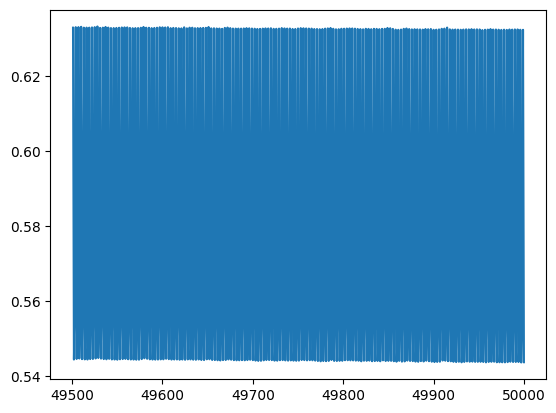

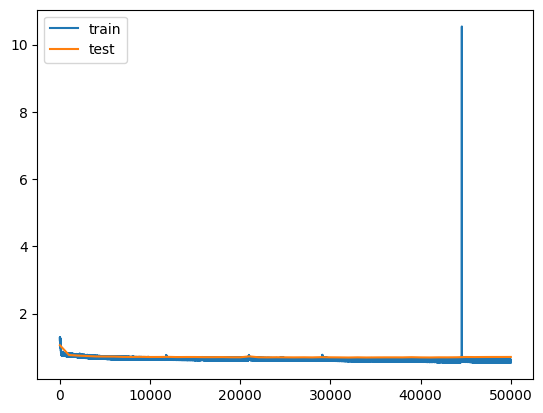

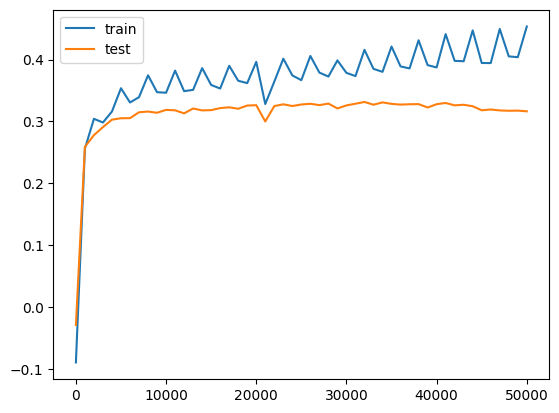

In [7]:
txt = [t[0] for t in results['train_losses']]
tlt = [t[1] for t in results['train_losses']]
plt.plot(txt[-500:], tlt[-500:], label="train")
plt.show()


plt.plot(txt, tlt, label="train")
tx = [t[0] for t in results['test_losses']]
tl = [t[1] for t in results['test_losses']]
plt.plot(tx, tl, label="test")
plt.legend()
plt.show()

tx = [t[0] for t in results['train_r2s']]
tr = [t[1] for t in results['train_r2s']]
plt.plot(tx, tr, label="train")
te = [t[1] for t in results['test_r2s']]
plt.plot(tx, te, label="test")
plt.legend()
plt.show()

tensor([-0.9311, -0.9050, -0.9102, -0.9156, -0.9110, -0.8842, -0.8759, -0.8812,
        -0.8287, -0.8405], device='cuda:0')
------
------
tensor([ 0.0503,  0.1563, -0.0233,  0.0865,  0.0719, -0.0415,  0.0620, -0.0731,
         0.0542, -0.0902], device='cuda:0') tensor([-0.0982, -0.4983,  0.0427, -0.2002, -0.2508,  0.1481, -0.1633,  0.2348,
        -0.1357,  0.3258], device='cuda:0')
tensor([-0.9311, -0.9051, -0.9102, -0.9156, -0.9110, -0.8842, -0.8760, -0.8812,
        -0.8287, -0.8406], device='cuda:0')


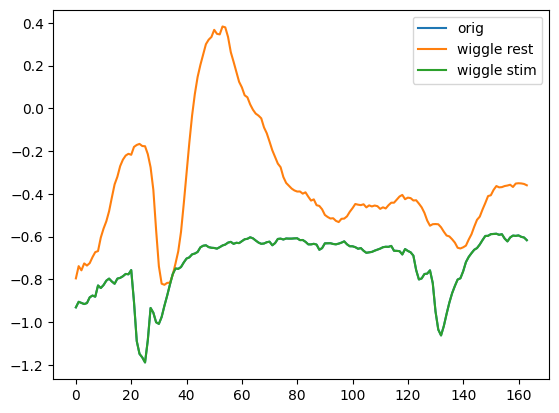

In [8]:
# see how much predictions change as I tweak embeddings
sid = "MonkeyG_20150917_Session3_S1"

def wiggle(stuff, quiet=True):
    out = {}
    for sid, thing in stuff.items():
        out[sid] = thing * (torch.rand(thing.shape).to(thing.device) + 0.5) * -3
    if not quiet:
        print(thing[:10], out[sid][:10])

    return out

ch = 30
    
with torch.no_grad():
    ms.eval()
    dt = next(iter(data_test))
    dt = utils.move_batch(dt, device=DEVICE)
    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=embeddings_stim)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="orig")
    print(preds[sid][0][:, ch][:10])
    print("------")
    
    preds = ms(dt, embeddings_rest=wiggle(embeddings_rest), embeddings_stim=embeddings_stim)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle rest")
    print("------")

    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=wiggle(embeddings_stim, quiet=False))
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle stim")
    print(preds[sid][0][:, ch][:10])
plt.legend()
plt.show()

In [17]:
print(ms.model.instances['MonkeyG_20150925_Session2_S1'].prev_bases[0])

tensor([[-1.6950, -1.6841, -1.5680,  ...,  1.0476, -1.6124,  1.8581],
        [ 1.5737,  0.8381,  0.6144,  ...,  0.4595, -1.4544, -0.4424],
        [ 1.9009,  0.6420,  0.6892,  ...,  1.8129,  1.1658,  1.8373],
        ...,
        [ 1.4457, -0.6197,  1.1864,  ...,  0.7964, -0.7746,  1.1812],
        [-0.5792, -0.3554,  1.8601,  ..., -0.8813, -0.4835,  1.3485],
        [ 1.0957, -1.2948,  1.0056,  ...,  0.2971, -0.7856,  0.9564]],
       device='cuda:0')


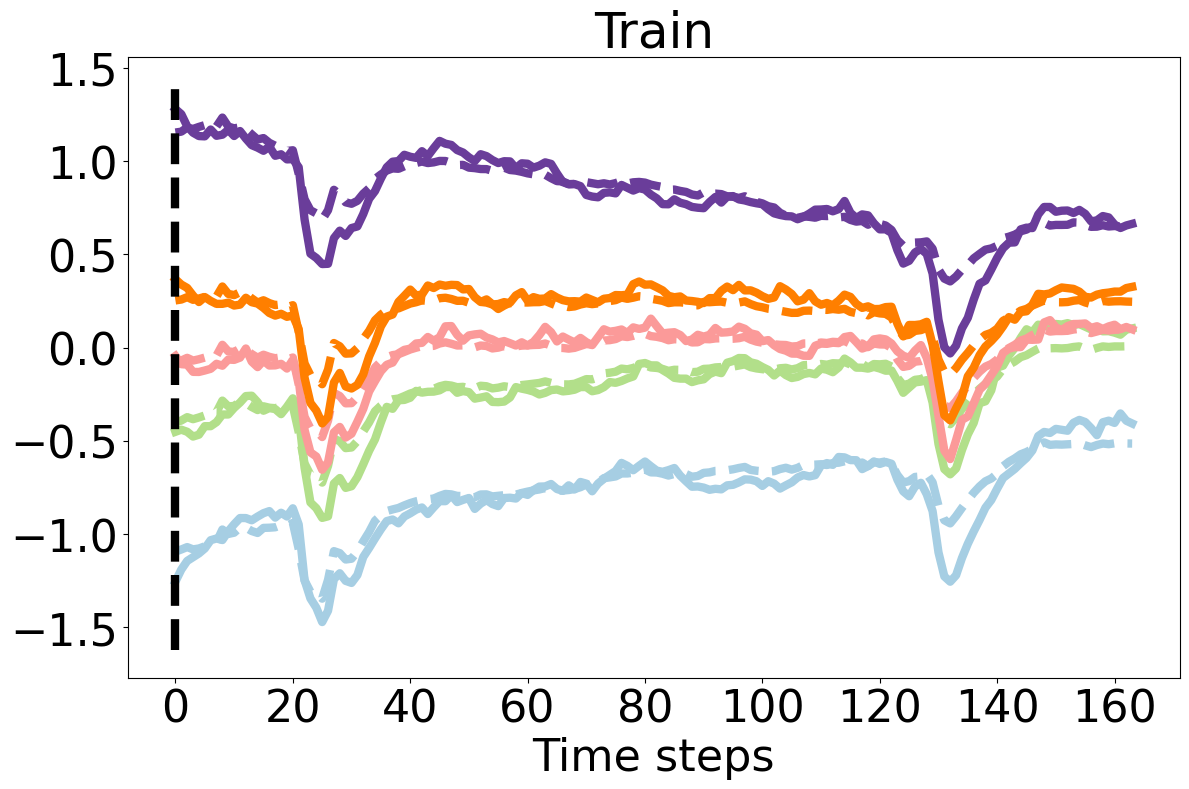

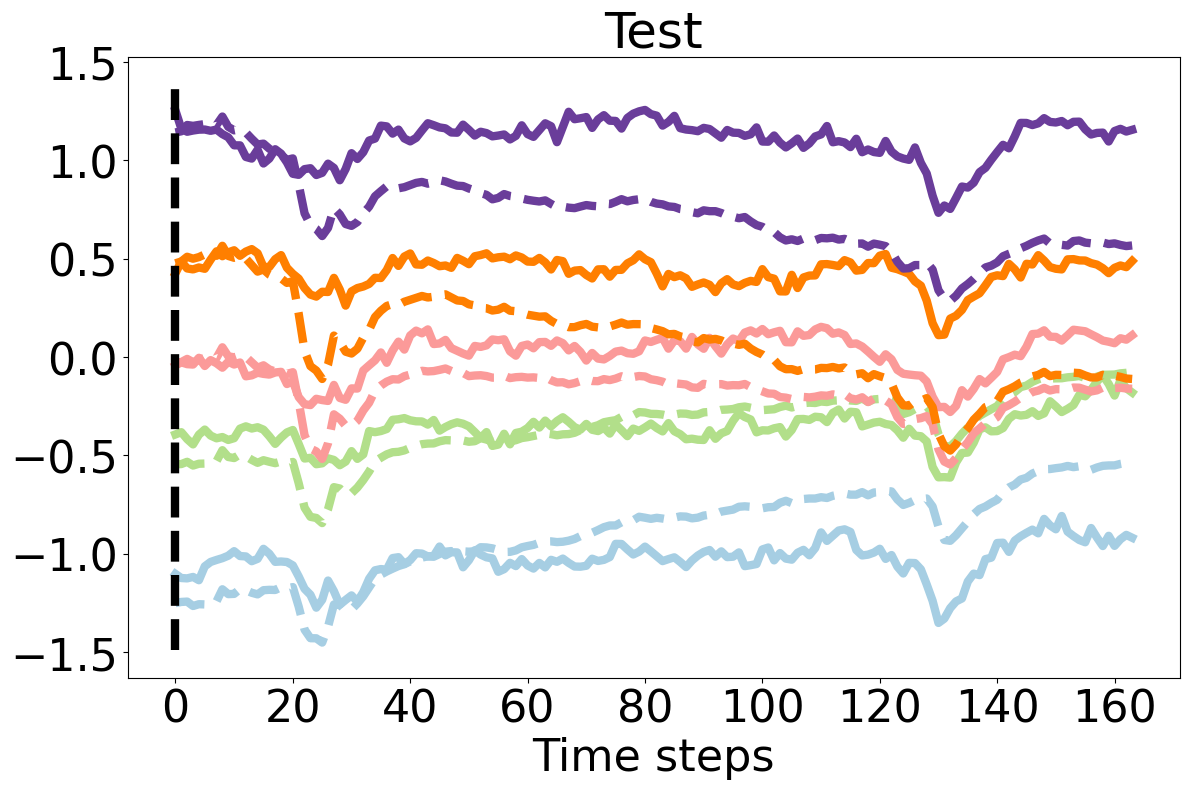

In [9]:
def graph_for_sid(sid, results, cidx=32):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()
    
    # y_hat_mean = torch.mean(y_hats, dim=0)
    # y_hat_test_mean = torch.mean(y_hats_test, dim=0)
    # y_mean = torch.mean(y, dim=0)
    # y_test_mean = torch.mean(y_test, dim=0)
    
    # bidx = 1000
    
    # plt.plot(y_hat_test_mean[:, cidx], label="hat")
    # plt.plot(y_test_mean[RUNWAY:, cidx], label="y")
    # plt.legend()
    # plt.show()
    test.graph_state_dependency(y, y_hats, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, title="Test", runway_length=0, ch=cidx)

# graph_for_sid('MonkeyG_20150925_Session2_S1', results, cidx=30)
# graph_for_sid('MonkeyJ_20160630_Session3_S1', results)
graph_for_sid('MonkeyG_20150917_Session3_S1', results)

In [ ]:
# Try:
# cfg.training.grad_clip = 2.0, 7.0
# cfg.tbfm.training.lambda_ortho = 0.01, 0.05, 0.1
# cfg.tbfm.module.num_bases = 15, 20, 25

for grad_clip in (2.0,):
    for num_bases in (15, 20, 25):
        for lambda_ortho in (0.01, 0.05, 0.1):
            print("---------------", grad_clip, num_bases, lambda_ortho)

            # cfg.tbfm.training.lambda_fro = regweight
            cfg.tbfm.module.num_bases = num_bases
            cfg.training.grad_clip = grad_clip
            # cfg.latent_dim = latent_dim
            # cfg.tbfm.training.optim.lr_head = lr_head
            cfg.tbfm.training.lambda_ortho = lambda_ortho
            cfg.tbfm.module.use_film_bases = True
            # cfg.ae.training.coadapt = True
            cfg.training.epochs = 20001

            ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
            model_optims = multisession.get_optims(cfg, ms)
            
            embeddings_stim, results = multisession.train_from_cfg(
                cfg,
                ms,
                data_train,
                model_optims,
                embeddings_rest,
                data_test=data_test,
                test_interval=5000,
                epochs=20001,
                )
            torch.save(results, f"res_{grad_clip}_{num_bases}_{lambda_ortho}.torch")

            del model_optims, ms

--------------- 2.0 15 0.01
Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 1.1330499649047852 0.9247554540634155 0.03832010179758072 0.061805590987205505
basis_weighting.weight         grad_norm=2.0000e+00, weight_norm=2.1510e+00, ratio=9.2982e-01
basis_weighting.bias           grad_norm=6.7800e-02, weight_norm=3.8891e+00, ratio=1.7433e-02
bases.in_layer.weight          grad_norm=4.7441e-03, weight_norm=3.3024e+00, ratio=1.4365e-03
bases.in_layer.bias            grad_norm=1.5774e-03, weight_norm=1.0543e+00, ratio=1.4962e-03
bases.hiddens.0.weight         grad_norm=1.9571e-03, weight_norm=3.9004e+00, ratio=5.0177e-04
bases.hiddens.0.bias           grad_norm=8.5569e-04, weight_norm=7.5115e-01, ratio=1.1392e-03
bases.hiddens.1.weight         grad_norm=1.9006e-03, weight_norm=3.8063e+00, ratio=4.9934e-04
bases.hiddens.1.bias           grad_norm=6.2266e-04, weight_norm=7.2910e-01, ratio=8.5402e-04
bases.out_layer.weight         

In [10]:
d = "."
f = [os.path.join(d, _f) for _f in os.listdir(d) if _f.startswith("res_") and _f.endswith(".torch")]
res = []
for _f in f:
    r = torch.load(_f)
    res.append((r["final_test_r2"], _f))
res.sort()

for rr in res[-10:]:
    print(rr)

# (0.4557589888572693, './res_0.07_17_70_10.0.torch')
# (0.4561246633529663, './res_0.05_12_50_10.0.torch')
# (0.45635348558425903, './res_0.01_17_70_10.0.torch')
# (0.4564235210418701, './res_0.07_17_70_1000.torch')
# (0.4569217562675476, './res_0.05_17_50_10.0.torch')
# (0.45701655745506287, './res_0.05_17_50_1000.torch')
# (0.4574051797389984, './res_0.05_20_70_1000.torch')
# (0.4576779007911682, './res_0.05_15_50_1000.torch')
# (0.45774632692337036, './res_0.05_15_70_1000.torch')
# (0.4579020142555237, './res_0.05_17_70_10.0.torch')

# Fro 0.05
# num_bases 17
# latent dim 70
# clip_grad None

(0.35666774378882515, './res_0.05_50_0.0003_0.2.torch')
(0.35697651902834576, './res_0.01_70_0.0003_0.3.torch')
(0.3569850954744551, './res_0.01_70_0.0001_0.1.torch')
(0.35736728376812404, './res_0.01_70_0.0001_0.3.torch')
(0.357471548848682, './res_0.01_50_0.0003_0.1.torch')
(0.35761067602369523, './res_0.01_70_0.0002_0.2.torch')
(0.35779477490319145, './res_0.01_70_0.0003_0.2.torch')
(0.3578372299671173, './res_0.01_70_0.0003_0.1.torch')
(0.35784753163655597, './res_0.01_50_0.0003_0.2.torch')
(0.357981413602829, './res_0.01_70_0.0002_0.1.torch')


In [7]:
cfg.tbfm.training.lambda_fro = 0.05
cfg.tbfm.module.num_bases = 17
cfg.latent_dim = 70
cfg.tbfm.module.use_film_bases = True
cfg.ae.training.coadapt = True

ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
model_optims = multisession.get_optims(cfg, ms)

embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=1000,
    epochs=15001,
    grad_clip=grad_clip
    )
multisession.save_model(ms, "session3.torch", tbfm_only=True)

Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 1.7282235622406006 1.4277710914611816 -0.7834978898366293 -0.4688534438610077
---- 1000 0.5889748334884644 0.5492038726806641 0.38332296907901764 0.43664056062698364
---- 2000 0.578731119632721 0.5410599708557129 0.3937474737564723 0.444960355758667
---- 3000 0.6143547296524048 0.5776938199996948 0.36004498104254407 0.40702182054519653
---- 4000 0.6094337701797485 0.551339864730835 0.36514731248219806 0.43505871295928955
---- 5000 0.568423867225647 0.5330778956413269 0.4050182302792867 0.4534160792827606
---- 6000 0.5660974383354187 0.535632848739624 0.4071046511332194 0.45071160793304443
---- 7000 0.562555193901062 0.5340944528579712 0.4104987432559331 0.45200562477111816
---- 8000 0.5612501502037048 0.5329346060752869 0.41190898418426514 0.45326513051986694
---- 9000 0.5625225901603699 0.5330714583396912 0.4108348786830902 0.4528921842575073
---- 10000 0.5645100474357605 0.53

In [9]:
print(results["final_test_r2s"])

{'MonkeyG_20150917_Session1_M1': tensor(0.2306, device='cuda:0'), 'MonkeyG_20150925_Session2_S1': tensor(0.6888, device='cuda:0'), 'MonkeyJ_20160630_Session3_S1': tensor(0.4499, device='cuda:0')}
